In [25]:
!pip install --upgrade transformers torch transformers[torch] tokenizers huggingface_hub pytorch-crf
!pip install protobuf==3.20.3

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable


In [38]:
import torch
torch.cuda.empty_cache()

assert torch.cuda.is_available()

In [39]:
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

Found device: NVIDIA A100-SXM4-80GB MIG 3g.40gb, n_gpu: 1


In [40]:
import random
import numpy as np

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_everything()

In [41]:
import pandas as pd

def read_conll(file_path):
    sentences = []
    labels = []
    current_sentence = []
    current_labels = []

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line:
                columns = line.split()
                word, label = columns[0], columns[-1]
                current_sentence.append(word)
                current_labels.append(label)
                
                # Check if the current word is a sentence boundary
                if word == '.' and label == 'O':
                    sentences.append(' '.join(current_sentence))
                    labels.append(current_labels)
                    current_sentence = []
                    current_labels = []

    # Create a DataFrame from the accumulated sentences and labels
    df = pd.DataFrame({
        'sentences': sentences,
        'labels': labels
    })
    return df


In [42]:
import torch
max_length=128

def tokenize_and_format(sentences, tokenizer, max_length=max_length):
    """
    Tokenizes sentences and returns formatted input IDs and attention masks.
    
    Parameters:
    sentences: List of sentence strings to be tokenized.
    tokenizer: Tokenizer instance used for tokenizing the sentences.
    """
    input_ids = []
    attention_masks = []

    # Encode each sentence
    for sentence in sentences:
        encoded_dict = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=max_length,  # Adjust based on your model's maximum input length
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # Store the input ID and the attention mask of this sentence
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert lists of tensors to single tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

In [43]:
from transformers import AutoTokenizer

model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)

In [44]:
label_dict = {
    'O': 0,
    'B-intervention': 1,
    'I-intervention': 2,
    'B-outcome': 3,
    'I-outcome': 4,
    'B-population': 5,
    'I-population': 6,
    'B-effect_size': 7,
    'I-effect_size': 8,
    'B-coreference': 9,
    'I-coreference': 10
}

In [45]:
reverse_label_dict = {v: k for k, v in label_dict.items()}

In [46]:
import numpy as np
import torch

def get_dataset(df, tokenizer, label_dict, max_length=max_length):
    """
    Processes a DataFrame to return a dataset suitable for training/testing an NER model.
    
    Parameters:
    df: DataFrame containing 'Tokens' and 'Labels' columns.
    tokenizer: Tokenizer to use for encoding the sentences.
    label_dict: Dictionary mapping label names to indices.
    max_length: Maximum length of the tokenized input.
    """
    sentences = df.sentences.values
    
    # Tokenize sentences
    input_ids, attention_masks = tokenize_and_format(sentences, tokenizer, max_length)

    # Prepare labels
    label_list = []
    for labels in df.labels.values:
        # Initialize a list to hold the encoded labels for each sentence
        encoded_labels = [label_dict[label] for label in labels]
        
        # Truncate or pad the labels to match the max_length
        encoded_labels = encoded_labels[:max_length]  # Truncate if needed
        encoded_labels += [label_dict['O']] * (max_length - len(encoded_labels))  # Pad with 'O' if needed
        
        label_list.append(encoded_labels)

    # Convert label_list to a tensor
    labels = torch.tensor(label_list, dtype=torch.long)

    # Create the dataset
    dataset = [(input_ids[i], attention_masks[i], labels[i]) for i in range(len(df))]

    return dataset, sentences

In [47]:
seed_everything()

train_df = read_conll('data/econ_ie/train.conll')
val_df = read_conll('data/econ_ie/dev.conll')
test_df = read_conll('data/econ_ie/test.conll')

train_set, train_sentences = get_dataset(train_df, tokenizer, label_dict)
val_set, val_sentences = get_dataset(val_df, tokenizer, label_dict)
test_set, test_sentences = get_dataset(test_df, tokenizer, label_dict)

In [48]:
train_set[0]

(tensor([  101,  1006,  1015,  1007,  3802,  2015, 16605,  2000, 11768, 10210,
         13340,  3508,  1999,  4405,  4655,  1998,  6088,  1012,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [49]:
# Set the hyperparameters according to Table 8
dropout = 0.2
learning_rates = [5e-5, 6e-5, 7e-5]  # Perform hyperparameter search
batch_size = 12
gradient_accumulation_steps = 4
weight_decay = 0
max_epochs = 10
lr_decay = "slanted_triangular"
fraction_of_steps = 0.06
adam_epsilon = 1e-8
adam_beta1 = 0.9
adam_beta2 = 0.999

seed_everything()

In [50]:
def preprocess_entities(labels, tokens):
    """
    Extract entities from token-label pairs.
    
    Args:
    labels (list of int): List of label indices corresponding to each token.
    tokens (list of str): List of tokens corresponding to each label index.
    
    Returns:
    list of tuples: Each tuple represents an entity with (entity_type, start_index, end_index, entity_text).
    """
    entities = []
    current_entity = None

    for i, (token, label) in enumerate(zip(tokens, labels)):
        if label.startswith("B-"):
            if current_entity:
                entities.append(current_entity)
            entity_type = label.split("-")[1]
            current_entity = (entity_type, i, i, token)
        elif label.startswith("I-") and current_entity and label.split("-")[1] == current_entity[0]:
            current_entity = (current_entity[0], current_entity[1], i, current_entity[3] + " " + token)
        else:
            if current_entity:
                entities.append(current_entity)
                current_entity = None

    if current_entity:
        entities.append(current_entity)

    return entities

In [51]:
def compute_entity_level_metrics(true_entities, pred_entities):
    metrics = {"EM": 0, "EB": 0, "PM": 0, "PB": 0, "ML": 0, "FA": 0}
    true_matched = set()
    pred_matched = set()

    # Check for exact and partial matches
    for i, true_entity in enumerate(true_entities):
        for j, pred_entity in enumerate(pred_entities):
            if j in pred_matched:
                continue
            if true_entity == pred_entity:
                metrics["EM"] += 1
                true_matched.add(i)
                pred_matched.add(j)
                break
            elif true_entity[0] == pred_entity[0] and is_overlapping((true_entity[1], true_entity[2]), (pred_entity[1], pred_entity[2])):
                if true_entity[1] == pred_entity[1] and true_entity[2] == pred_entity[2]:
                    metrics["EB"] += 1
                else:
                    metrics["PM"] += 1
                true_matched.add(i)
                pred_matched.add(j)
                break
            elif is_overlapping((true_entity[1], true_entity[2]), (pred_entity[1], pred_entity[2])):
                metrics["PB"] += 1
                true_matched.add(i)
                pred_matched.add(j)
                break

    # Check for missed labels (entities in true but not in pred)
    for i, true_entity in enumerate(true_entities):
        if i not in true_matched:
            metrics["ML"] += 1

    # Check for false alarms (entities in pred but not in true)
    for j, pred_entity in enumerate(pred_entities):
        if j not in pred_matched:
            metrics["FA"] += 1

    return metrics

In [52]:
def is_overlapping(span1, span2):
    """
    Check if two spans overlap.
    Args:
    span1, span2 (tuple): (start_index, end_index) of the span.

    Returns:
    bool: True if spans overlap, False otherwise.
    """
    assert len(span1) == 2 and len(span2) == 2, "Each span must be a tuple of two elements (start_index, end_index)"
    start1, end1 = span1
    start2, end2 = span2
    return max(start1, start2) <= min(end1, end2)

In [53]:
print(label_dict)

{'O': 0, 'B-intervention': 1, 'I-intervention': 2, 'B-outcome': 3, 'I-outcome': 4, 'B-population': 5, 'I-population': 6, 'B-effect_size': 7, 'I-effect_size': 8, 'B-coreference': 9, 'I-coreference': 10}


In [54]:
from collections import defaultdict

def analyze_generalization(model, data, tokenizer, train_words):
    grouped_entities = defaultdict(lambda: ([], []))  # {group_name: (true_entities, pred_entities)}        
    groups=[]
    mtrcs=[]

    for i, (input_ids, attention_mask, label_tensor) in enumerate(data):
        input_ids = input_ids.unsqueeze(0).to(device)
        attention_mask = attention_mask.unsqueeze(0).to(device)
        
        # Call model without labels to get the decoded labels
        with torch.no_grad():
            decoded_labels = model(input_ids, attention_mask=attention_mask)["decoded"][0]
            # No need to use argmax since CRF.decode returns the most likely tag sequence
        
        # Convert the decoded labels to label names using label_dict
        pred_labels = [reverse_label_dict.get(label) for label in decoded_labels]

        # Convert input_ids to tokens
        tokens = tokenizer.convert_ids_to_tokens(input_ids[0].tolist(), skip_special_tokens=True)

        # Assuming true_labels are provided in a similar structure
        true_labels = [reverse_label_dict.get(l.item()) for l in label_tensor]
        
        # Preprocess entities for true and predicted labels
        true_entities = preprocess_entities(true_labels, tokens)
        pred_entities = preprocess_entities(pred_labels, tokens)
        
        for true_entity, pred_entity in zip(true_entities, pred_entities):
            length = true_entity[2] - true_entity[1]

            seen = any(word in train_words for word in true_entity[3].split())  # Check if any word in entity text was seen in training

            group_name = f"Length {length} - {'Seen' if seen else 'Unseen'}"
            grouped_entities[group_name][0].append(true_entity)
            grouped_entities[group_name][1].append(pred_entity)
    
    for group_name, group_data in grouped_entities.items():
        group_true_entities, group_pred_entities = group_data
        metrics = compute_entity_level_metrics(group_true_entities, group_pred_entities)
        print(f"Group: {group_name}, Metrics: {metrics}")
        groups.append(group_name)
        mtrcs.append(metrics)
        
    return groups, mtrcs

In [55]:
from sklearn.metrics import classification_report
import torch
import numpy as np

def get_validation_performance(val_set, model, device, label_dict, batch_size):
    # Put the model in evaluation mode
    model.eval()

    # Tracking variables
    total_eval_loss = 0
    all_pred_labels = []
    all_true_labels = []

    num_batches = int(len(val_set) / batch_size) + (1 if len(val_set) % batch_size != 0 else 0)

    for i in range(num_batches):
        end_index = min(batch_size * (i + 1), len(val_set))
        batch = val_set[i * batch_size:end_index]

        if len(batch) == 0:
            continue

        input_id_tensors = torch.stack([data[0] for data in batch])
        input_mask_tensors = torch.stack([data[1] for data in batch])
        label_tensors = torch.stack([data[2] for data in batch])

        # Move tensors to the GPU
        b_input_ids = input_id_tensors.to(device)
        b_input_mask = input_mask_tensors.to(device)
        b_labels = label_tensors.to(device)
        b_labels = b_labels.long()

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs["loss"]
            logits = outputs["logits"]

            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Get the predicted labels
            pred_labels = np.argmax(logits, axis=2).flatten()
            true_labels = label_ids.flatten()

            # Convert labels to their original names
            pred_labels = [reverse_label_dict.get(label) for label in pred_labels]
            true_labels = [reverse_label_dict.get(label) for label in true_labels]

            # Filter out special tokens ('O' label is used for non-entity and special tokens)
            filtered_pred_labels = [pred for pred, true in zip(pred_labels, true_labels) if true != 'O']
            filtered_true_labels = [true for true in true_labels if true != 'O']
            
            # After filtering out special tokens
            if not filtered_pred_labels or not filtered_true_labels:
                print("Warning: No non-'O' labels found in this batch.")
            else:
                all_pred_labels.extend(filtered_pred_labels)
                all_true_labels.extend(filtered_true_labels)
            
    # After processing all batches, check if we have any labels to report on
    if not all_true_labels or not all_pred_labels:
        print("Error: No non-'O' labels found in the entire validation set.")
        default_labels = [list(label_dict.values())[0]]  # Use the first label as a placeholder
        report = classification_report(default_labels, default_labels, digits=4, zero_division=0)
    else:
        # Calculate precision, recall, and F1 score
        report = classification_report(all_true_labels, all_pred_labels, digits=4, zero_division=0)

    return report


In [56]:
from torchcrf import CRF
from transformers import AutoModel

class CRFTagger(torch.nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = torch.nn.Dropout(dropout)
        self.classifier = torch.nn.Linear(self.bert.config.hidden_size, num_labels)
        self.crf = CRF(num_labels, batch_first=True)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        sequence_output = outputs[0]
        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        # Mask should be of type 'bool' in newer PyTorch versions
        mask = attention_mask.type(torch.bool) if hasattr(torch, 'bool') else attention_mask.byte()
        
        if labels is not None:
            loss = -self.crf(logits, labels, mask=mask, reduction='mean')
            return {'loss': loss, 'logits': logits, 'decoded': self.crf.decode(logits, mask=mask)}
        else:
            decoded_labels = self.crf.decode(logits, mask=mask)
            return {'decoded': decoded_labels, 'logits': logits}

In [57]:
seed_everything()

# Load the pre-trained model
model = CRFTagger(model_name, len(label_dict))
model.dropout = torch.nn.Dropout(dropout)
model.to(device)

CRFTagger(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=

In [56]:
from transformers import get_linear_schedule_with_warmup, AdamW
import time

# Calculate the total number of training steps
total_steps = (len(train_set) // (batch_size * gradient_accumulation_steps)) * max_epochs


for lr in learning_rates:
    print(f"Current learning rate: {lr}")

    # Create the optimizer with the specified hyperparameters
    optimizer = AdamW(model.parameters(), lr=lr, eps=adam_epsilon, betas=(adam_beta1, adam_beta2), weight_decay=weight_decay, no_deprecation_warning=True)

    # Create the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(total_steps * fraction_of_steps), num_training_steps=total_steps)

    # Training loop
    for epoch_i in range(max_epochs):
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, max_epochs))
        print('Training...')

        total_train_loss = 0
        model.train()

        num_batches = int(len(train_set) / batch_size) + (1 if len(train_set) % batch_size != 0 else 0)

        for i in range(num_batches):
            end_index = min(batch_size * (i + 1), len(train_set))
            batch = train_set[i * batch_size:end_index]

            if len(batch) == 0:
                continue

            input_id_tensors = torch.stack([data[0] for data in batch])
            input_mask_tensors = torch.stack([data[1] for data in batch])
            label_tensors = torch.stack([data[2] for data in batch])

            b_input_ids = input_id_tensors.to(device)
            b_input_mask = input_mask_tensors.to(device)
            b_labels = label_tensors.long().to(device)

            model.zero_grad()
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs["loss"]
            total_train_loss += loss.item()

            # Accumulate gradients
            loss = loss / gradient_accumulation_steps
            loss.backward()

            # Perform optimizer step after accumulating gradients for gradient_accumulation_steps
            if (i + 1) % gradient_accumulation_steps == 0 or i == num_batches - 1:  # Ensure step is taken on the last batch
                optimizer.step()
                scheduler.step()
                model.zero_grad()

        print(f"Total loss: {total_train_loss}")
        report = get_validation_performance(val_set, model, device, label_dict, batch_size)
        print(report)
        analyze_generalization(model, val_set, tokenizer, train_sentences)

    print("")
    print(f"Training complete at learning rate: {lr}!")

    timestamp = time.strftime("%Y%m%d-%H%M%S")
    print(f"mDeBERTa Model saved at: {timestamp}")
    torch.save(model.state_dict(), f'mdebertamodel_lr-{lr}_{timestamp}.pth')

print("")
print(f"Training complete!")

Current learning rate: 5e-05

======== Epoch 1 / 10 ========
Training...
Total loss: 16016.201522827148
                precision    recall  f1-score   support

 B-coreference     0.0000    0.0000    0.0000       255
 B-effect_size     0.0000    0.0000    0.0000       142
B-intervention     0.0000    0.0000    0.0000       704
     B-outcome     0.3333    0.0010    0.0019      1035
  B-population     0.0000    0.0000    0.0000       598
 I-coreference     0.0000    0.0000    0.0000         7
 I-effect_size     0.0000    0.0000    0.0000       247
I-intervention     0.7718    0.1163    0.2021      1600
     I-outcome     0.4481    0.1790    0.2558      1760
  I-population     0.0000    0.0000    0.0000       618
             O     0.0000    0.0000    0.0000         0

      accuracy                         0.0721      6966
     macro avg     0.1412    0.0269    0.0418      6966
  weighted avg     0.3400    0.0721    0.1113      6966


======== Epoch 2 / 10 ========
Training...
Total los

In [23]:
# Load state_dict of the model
model.load_state_dict(torch.load(f'models/BERT_model_lr-7e-05_best.pth'))

<All keys matched successfully>

In [24]:
print(get_validation_performance(test_set, model, device, label_dict, batch_size))

                precision    recall  f1-score   support

 B-coreference     0.8250    0.3000    0.4400       550
 B-effect_size     0.4949    0.1531    0.2339       320
B-intervention     0.6344    0.3797    0.4751      1330
     B-outcome     0.5298    0.3161    0.3959      1718
  B-population     0.5601    0.3802    0.4529      1018
 I-coreference     0.0000    0.0000    0.0000        22
 I-effect_size     0.6333    0.1971    0.3006       482
I-intervention     0.7436    0.5054    0.6018      2663
     I-outcome     0.7502    0.3675    0.4934      3235
  I-population     0.8009    0.4132    0.5452      1227
             O     0.0000    0.0000    0.0000         0

      accuracy                         0.3809     12565
     macro avg     0.5429    0.2738    0.3581     12565
  weighted avg     0.6869    0.3809    0.4857     12565



In [25]:
bert_lengths, bert_metrics = analyze_generalization(model, test_set, tokenizer, train_sentences)

Group: Length 3 - Unseen, Metrics: {'EM': 1, 'EB': 4, 'PM': 100, 'PB': 171, 'ML': 12, 'FA': 12}
Group: Length 4 - Unseen, Metrics: {'EM': 7, 'EB': 0, 'PM': 58, 'PB': 95, 'ML': 10, 'FA': 10}
Group: Length 0 - Unseen, Metrics: {'EM': 107, 'EB': 253, 'PM': 82, 'PB': 1059, 'ML': 72, 'FA': 72}
Group: Length 2 - Unseen, Metrics: {'EM': 8, 'EB': 11, 'PM': 138, 'PB': 287, 'ML': 25, 'FA': 25}
Group: Length 1 - Unseen, Metrics: {'EM': 41, 'EB': 40, 'PM': 323, 'PB': 609, 'ML': 33, 'FA': 33}
Group: Length 5 - Unseen, Metrics: {'EM': 3, 'EB': 2, 'PM': 55, 'PB': 60, 'ML': 6, 'FA': 6}
Group: Length 9 - Unseen, Metrics: {'EM': 1, 'EB': 0, 'PM': 8, 'PB': 10, 'ML': 6, 'FA': 6}
Group: Length 7 - Unseen, Metrics: {'EM': 1, 'EB': 0, 'PM': 19, 'PB': 24, 'ML': 3, 'FA': 3}
Group: Length 10 - Unseen, Metrics: {'EM': 0, 'EB': 0, 'PM': 6, 'PB': 6, 'ML': 3, 'FA': 3}
Group: Length 8 - Unseen, Metrics: {'EM': 1, 'EB': 0, 'PM': 22, 'PB': 20, 'ML': 5, 'FA': 5}
Group: Length 11 - Unseen, Metrics: {'EM': 0, 'EB': 0, 'P

In [26]:
lengths

['Length 3 - Unseen',
 'Length 4 - Unseen',
 'Length 0 - Unseen',
 'Length 2 - Unseen',
 'Length 1 - Unseen',
 'Length 5 - Unseen',
 'Length 9 - Unseen',
 'Length 7 - Unseen',
 'Length 10 - Unseen',
 'Length 8 - Unseen',
 'Length 11 - Unseen',
 'Length 6 - Unseen',
 'Length 12 - Unseen',
 'Length 13 - Unseen',
 'Length 16 - Unseen',
 'Length 17 - Unseen',
 'Length 18 - Unseen',
 'Length 32 - Unseen',
 'Length 14 - Unseen',
 'Length 19 - Unseen']

In [27]:
metrics

[{'EM': 1, 'EB': 4, 'PM': 100, 'PB': 171, 'ML': 12, 'FA': 12},
 {'EM': 7, 'EB': 0, 'PM': 58, 'PB': 95, 'ML': 10, 'FA': 10},
 {'EM': 107, 'EB': 253, 'PM': 82, 'PB': 1059, 'ML': 72, 'FA': 72},
 {'EM': 8, 'EB': 11, 'PM': 138, 'PB': 287, 'ML': 25, 'FA': 25},
 {'EM': 41, 'EB': 40, 'PM': 323, 'PB': 609, 'ML': 33, 'FA': 33},
 {'EM': 3, 'EB': 2, 'PM': 55, 'PB': 60, 'ML': 6, 'FA': 6},
 {'EM': 1, 'EB': 0, 'PM': 8, 'PB': 10, 'ML': 6, 'FA': 6},
 {'EM': 1, 'EB': 0, 'PM': 19, 'PB': 24, 'ML': 3, 'FA': 3},
 {'EM': 0, 'EB': 0, 'PM': 6, 'PB': 6, 'ML': 3, 'FA': 3},
 {'EM': 1, 'EB': 0, 'PM': 22, 'PB': 20, 'ML': 5, 'FA': 5},
 {'EM': 0, 'EB': 0, 'PM': 3, 'PB': 2, 'ML': 3, 'FA': 3},
 {'EM': 1, 'EB': 0, 'PM': 31, 'PB': 60, 'ML': 7, 'FA': 7},
 {'EM': 0, 'EB': 0, 'PM': 3, 'PB': 0, 'ML': 1, 'FA': 1},
 {'EM': 0, 'EB': 0, 'PM': 2, 'PB': 1, 'ML': 1, 'FA': 1},
 {'EM': 0, 'EB': 0, 'PM': 1, 'PB': 1, 'ML': 1, 'FA': 1},
 {'EM': 0, 'EB': 0, 'PM': 0, 'PB': 1, 'ML': 0, 'FA': 0},
 {'EM': 0, 'EB': 0, 'PM': 3, 'PB': 0, 'ML': 

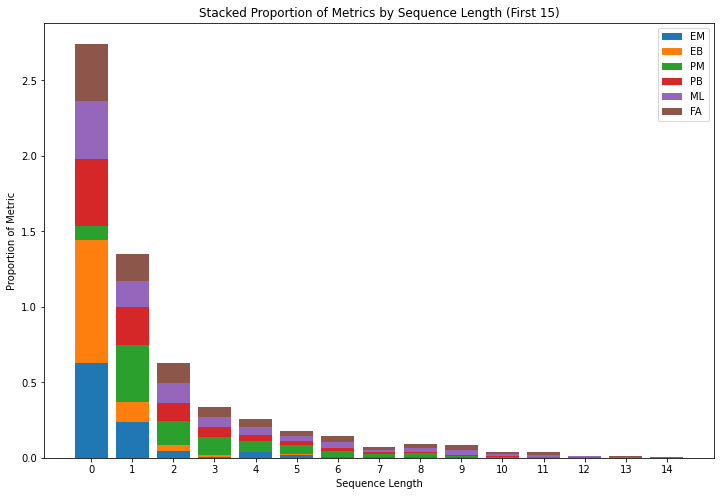

In [32]:
import matplotlib.pyplot as plt

# Extract sequence lengths and sort data by sequence length
sequence_lengths = [int(s.split()[1]) for s in bert_lengths]
sorted_indices = sorted(range(len(sequence_lengths)), key=lambda x: sequence_lengths[x])
sequence_lengths = [sequence_lengths[i] for i in sorted_indices]

# Calculate proportions for each metric
metrics_keys = ['EM', 'EB', 'PM', 'PB', 'ML', 'FA']  # Add other metric keys if needed
proportions = {key: [] for key in metrics_keys}

for key in metrics_keys:
    metric_values = [bert_metrics[i][key] for i in sorted_indices]
    metric_total = sum(metric_values)
    proportions[key] = [value / metric_total for value in metric_values]

# Plot each metric using stacked bar graphs for the first 15 sequence lengths
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the figure size as needed

# Positions of the bars on the x-axis
indices = range(len(sequence_lengths[:15]))

# Initialize the bottom for the stack
bottom = [0] * 15

for key in metrics_keys:
    ax.bar(indices, proportions[key][:15], bottom=bottom, label=key)
    # Update the bottom position for the next metric
    bottom = [bottom[i] + proportions[key][i] for i in range(15)]

# Labeling
ax.set_xlabel('Entity Length')
ax.set_ylabel('Proportion of Entities')
ax.set_title('Proportion of Entities by Sequence Length (First 15)')
ax.set_xticks(indices)
ax.set_xticklabels(sequence_lengths[:15])
ax.legend()

plt.show()

In [1]:
!pip install checklist

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 87.9 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 68.9 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.4/167.4 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached typing_extensions-4.5.0-py3-none-any.whl.metadata (8.5 kB)
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of typeguard to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of typeguard to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to redu

In [24]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /home/apathak2/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [58]:
import checklist
from checklist.editor import Editor
from checklist.perturb import Perturb
from checklist.test_types import MFT, INV, DIR
from checklist.expect import Expect
editor = Editor()

In [59]:
def extract_entities(df):
    # Assuming df has columns 'sentences' and 'labels'
    entities = []
    current_entity = None

    for index, row in df.iterrows():
        sentence = row['sentences']
        labels = row['labels']
        words = sentence.split()

        for i, (word, label) in enumerate(zip(words, labels)):
            if label.startswith('B-'):
                if current_entity:
                    entities.append(current_entity)
                current_entity = {'type': label[2:], 'start_idx': i, 'end_idx': i, 'text': word}
            elif label.startswith('I-') and current_entity and label[2:] == current_entity['type']:
                current_entity['end_idx'] = i
                current_entity['text'] += ' ' + word
            else:
                if current_entity:
                    entities.append(current_entity)
                    current_entity = None

        if current_entity:
            entities.append(current_entity)
            current_entity = None

    return entities

In [60]:
entities = extract_entities(train_df)
print(len(entities))

15872


In [61]:
# Define templates with placeholders for populations
population_templates = (
    'The study focused on {population}.',
    'Results were most significant among {population}.',
    'The impact on {population} was noteworthy.',
    'Interventions were targeted towards {population}.',
    'Data was collected from various {population}.',
    'The {population} showed a remarkable response.',
    'Surveys were conducted across different {population}.',
    'The {population} was observed for changes.',
    'A significant change was recorded in the {population}.',
    'The research aimed to benefit the {population}.'
)

# Define custom population entity
populations = [entity['text'] for entity in entities if entity['type']=='population']

# Use the editor to create examples
population_test_cases = editor.template(
    population_templates, 
    meta=True,
    remove_duplicates=True,
    population=populations
)
    
def found_population(x, pred, conf, label=None, meta=None):
    # Check if 'population' is the only entity type present in the prediction
    expected_population = meta['population']
    return all(label == 'O' or label.endswith('population') for label in pred)

found_population_expect_fn = Expect.single(found_population)

# A simple MFT test
found_population_test = MFT(
    **population_test_cases,
    name='Test for correct population recognition',
    capability='NER',
    description='The model should correctly identify and label populations.',
    expect=found_population_expect_fn
)

In [62]:
# Define templates with placeholders for interventions
intervention_templates = (
    "The {intervention} was implemented to address the issue.",
    "Researchers studied the effects of the {intervention}.",
    "The {intervention} had a significant impact on the community.",
    "Funding was provided for the {intervention}.",
    "The success of the {intervention} was evident in the results.",
    "Participants were selected for the {intervention} group.",
    "The {intervention} was a key part of the strategy.",
    "The {intervention} targeted specific outcomes.",
    "Outcomes were measured after the {intervention} took place.",
    "The {intervention} was designed to improve overall outcomes."
)

# Define custom intervention entity
interventions = [entity['text'] for entity in entities if entity['type']=='intervention']

# Use the editor to create examples
intervention_test_cases = editor.template(
    intervention_templates, 
    meta=True,
    remove_duplicates=True,
    intervention=interventions
)

def found_intervention(x, pred, conf, label=None, meta=None):
    # Check if 'intervention' is the only entity type present in the prediction
    expected_intervention = meta['intervention']
    return all(label == 'O' or label.endswith('intervention') for label in pred)

found_intervention_expect_fn = Expect.single(found_intervention)    

# A simple MFT test
found_intervention_test = MFT(
    **intervention_test_cases,
    name='Test for correct intervention recognition',
    capability='NER',
    description='The model should correctly identify and label interventions.',
    expect=found_intervention_expect_fn
)

In [63]:
# Define templates with placeholders for outcomes
outcome_templates = (
    "The outcome of the study was {outcome}.",
    "It was observed that the primary outcome was {outcome}.",
    "The expected outcome was {outcome}, which was surprising.",
    "As a result, the outcome was {outcome}.",
    "The final outcome, {outcome}, was recorded after the experiment.",
    "The result of the intervention was {outcome}.",
    "The project led to {outcome}.",
    "The consequences were observed as {outcome}.",
    "The end effect was {outcome}.",
    "The study concluded with {outcome}."
)

# Define custom outcome entity
outcomes = [entity['text'] for entity in entities if entity['type']=='outcome']

# Use the editor to create examples
outcome_test_cases = editor.template(
    outcome_templates, 
    meta=True,
    remove_duplicates=True,
    outcome=outcomes
)

def found_outcome(x, pred, conf, label=None, meta=None):
    # Check if 'outcome' is the only entity type present in the prediction
    expected_outcome = meta['outcome']
    return all(label == 'O' or label.endswith('outcome') for label in pred)

found_outcome_expect_fn = Expect.single(found_outcome)    

# A simple MFT test
found_outcome_test = MFT(
    **outcome_test_cases,
    name='Test for correct outcome recognition',
    capability='NER',
    description='The model should correctly identify and label outcomes.',
    expect=found_outcome_expect_fn
)

In [64]:
# Define templates with placeholders for effect_sizes
effect_size_templates = (
    "The observed change was {effect_size}.",
    "A {effect_size} increase was noted in the study.",
    "The results showed a {effect_size} decrease.",
    "There was a {effect_size} improvement over the baseline.",
    "The effect was quantified as {effect_size}.",
    "The magnitude of impact measured {effect_size}.",
    "The statistical significance reached {effect_size}.",
    "A {effect_size} reduction in errors was achieved.",
    "The intervention led to a {effect_size} enhancement.",
    "The data indicated a {effect_size} growth rate."
)

# Define custom effect_size entity
effect_sizes = [entity['text'] for entity in entities if entity['type']=='effect_size']

# Use the editor to create examples
effect_size_test_cases = editor.template(
    effect_size_templates, 
    meta=True,
    remove_duplicates=True,
    effect_size=effect_sizes
)

def found_effect_size(x, pred, conf, label=None, meta=None):
    # Check if 'effect_size' is the only entity type present in the prediction
    expected_effect_size = meta['effect_size']
    return all(label == 'O' or label.endswith('effect_size') for label in pred)

found_effect_size_expect_fn = Expect.single(found_effect_size)    

# A simple MFT test
found_effect_size_test = MFT(
    **effect_size_test_cases,
    name='Test for correct effect-size recognition',
    capability='NER',
    description='The model should correctly identify and label effect-size.',
    expect=found_effect_size_expect_fn
)

In [65]:
# Define templates with placeholders for coreferences
coreference_templates = (
    "This refers to the {coreference}.",
    "Such instances of {coreference} were noted.",
    "As mentioned earlier, the {coreference} plays a crucial role.",
    "This is similar to the {coreference} discussed before.",
    "The case of {coreference} is particularly interesting.",
    "In light of the {coreference}, further analysis is required.",
    "This aligns with the {coreference} we observed.",
    "The {coreference} under discussion was pivotal.",
    "Reflecting on the {coreference}, it becomes clear.",
    "Given the {coreference}, the results are unsurprising."
)

# Define custom coreference entity
coreferences = [entity['text'] for entity in entities if entity['type']=='coreference']

# Use the editor to create examples
coreference_test_cases = editor.template(
    coreference_templates, 
    meta=True,
    remove_duplicates=True,
    coreference=coreferences
)

def found_coreference(x, pred, conf, label=None, meta=None):
    # Check if 'coreference' is the only entity type present in the prediction
    expected_coreference = meta['coreference']
    return all(label == 'O' or label.endswith('coreference') for label in pred)

found_coreference_expect_fn = Expect.single(found_coreference)    

# A simple MFT test
found_coreference_test = MFT(
    **coreference_test_cases,
    name='Test for correct coreference recognition',
    capability='NER',
    description='The model should correctly identify and label coreference.',
    expect=found_coreference_expect_fn
)

In [66]:
# # Define an INV test that adds typos to the sentence
# Inv = INV(
#     name='Test for robustness to typos',
#     capability='Robustness',
#     description='The model should be robust to typos in the input.',
#     data=Perturb.perturb(['The government implemented a new intervention to boost economic growth.'], Perturb.add_typos).data,
#     expect=expect_fn
# )

In [67]:
# # Define a DIR test that negates the sentence
# Dir = DIR(
#     name='Test for sensitivity to negations',
#     capability='Negation',
#     description='The model should change predictions when negations are added.',
#     data=[('The government implemented a new intervention to boost economic growth.', 'The government did not implement a new intervention to boost economic growth.', {'entities': ['B-intervention', 'I-intervention', 'O', 'O', 'O', 'O', 'B-outcome'], 'negated_entities': ['O']*7} )],
#     expect=expect_fn
# )

In [68]:
from checklist.test_suite import TestSuite

suite = TestSuite()
suite.add(found_population_test)
suite.add(found_intervention_test)
suite.add(found_outcome_test)
suite.add(found_effect_size_test)
suite.add(found_coreference_test)
# suite.add(Inv)
# suite.add(Dir)

In [ ]:
model_name = model_name
lr = learning_rates[0]

# Load state_dict of the model
model.load_state_dict(torch.load(f'models/EconBERTa_model_lr-7e-05_best.pth'))

In [262]:
def predict(texts):
    # Extract just the sentences from the input tuples
    sentences = [text[0] for text in texts]
    
    # Convert texts to input IDs and attention masks using the tokenizer
    input_ids, attention_mask = tokenize_and_format(sentences, tokenizer, max_length)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    
    # Use the model to get the logits
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    
    # Decode the outputs using the CRF layer
    decoded_labels = outputs['decoded']
    
    # Convert label indices to label names
    pred_labels = [[reverse_label_dict[label] for label in sentence_labels] for sentence_labels in decoded_labels]
    return pred_labels

In [263]:
from checklist.pred_wrapper import PredictorWrapper
predict_and_conf = PredictorWrapper.wrap_predict(predict)

In [264]:
# Run the test suite
suite.run(predict_and_conf)

Running Test for correct population recognition
Predicting 3205 examples
Running Test for correct intervention recognition
Predicting 4120 examples
Running Test for correct outcome recognition
Predicting 5870 examples
Running Test for correct effect-size recognition
Predicting 965 examples
Running Test for correct coreference recognition
Predicting 1712 examples


In [265]:
suite.summary()

NER

Test for correct population recognition
Test cases:      3205
Fails (rate):    241 (7.5%)

Example fails:
['O', 'O', 'O', 'O', 'B-intervention', 'I-intervention', 'O', 'O', 'O'] ('The study focused on household contacts.', 'Results were most significant among household contacts.', 'The impact on household contacts was noteworthy.', 'Interventions were targeted towards household contacts.', 'Data was collected from various household contacts.', 'The household contacts showed a remarkable response.', 'Surveys were conducted across different household contacts.', 'The household contacts was observed for changes.', 'A significant change was recorded in the household contacts.', 'The research aimed to benefit the household contacts.')

----
['O', 'O', 'O', 'O', 'B-population', 'O', 'B-intervention', 'I-intervention', 'I-intervention', 'B-intervention', 'I-intervention', 'I-intervention', 'I-intervention', 'I-intervention', 'I-intervention', 'O', 'O', 'B-intervention', 'I-intervention',

In [266]:
suite.visual_summary_table()

Please wait as we prepare the table data...


SuiteSummarizer(stats={'npassed': 0, 'nfailed': 0, 'nfiltered': 0}, test_infos=[{'name': 'Test for correct pop…